# Objetivo

Cruzar assunto com tipos de sentença

## Query mensagens

In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.util import ngrams
import acessos as ac
from arabica import arabica_freq
from unidecode import unidecode
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
query = """

select 
msg.id_issue
, msg.dt_envio_mensagem
, nm_entidade
, msg.ds_message
, novas_tags.hierarquia_4
, novas_tags.fila_de_atendimento
from cx_curated_zone.helpshift_issues_messages msg
left join "cx_curated_zone"."helpshift_issues" AS issues_macro ON msg."id_issue" = issues_macro."id_issue"
left join "cx_curated_zone"."helpshift_tag_niveis" AS helpshift_tag ON msg."id_issue" = helpshift_tag."id_issue"
left join processed_zone_api_cxm_tags.tags_hierarquia_gerencial as novas_tags ON trim(lower(n3)) = trim(lower(nm_tag_n3))
where ds_entidade = 'bot'
and dt_envio_mensagem >= to_date('2022-10-01','yyyy-mm-dd')
order by rand() desc
limit 50000

"""

df = ac.df_athena('flavia-costa', query)

## Funções de tratamento

In [3]:
def replace_unuseful_messages(text):
    '''
    Replace automatic and irrelevant (for the project purpose) messages with empty string
    '''
    unuseful_messages = [
        'Outros assuntos',
        'Quero falar de outra coisa',
        'Quero resolver uma coisa',
        'Falar com atendente',
        '&Eacute; outra coisa',
        '&Eacute; outro assunto',
        'Voltar pro come&ccedil;o',
        '&Eacute; outro motivo',
        'Quero falar com atendente',
        'Me mostra as op&ccedil;&otilde;es de antes',
        'Quero falar de outro assunto',
        '&Eacute; outro assunto',
        '&Eacute; outra coisa ',
        'N&atilde;o, ainda tenho d&uacute;vidas',
        'Nenhuma das op&ccedil;&otilde;es',
        'Falar de outra coisa',
        'Quero voltar pro come&ccedil;o',
        'Voltar pro come&ccedil;o',
        'Falar com atendente',
        'Pode sim Por favor',
        'Não, ainda tenho dúvidas',
        'Certo',
        'Obrigado',
        'Responde'
    ]

    if text.strip() in unuseful_messages:
        return ''

    return text

In [4]:
def remove_emoji(text):
    '''
    Replace emojis with empty string
    '''
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', str(text))

In [5]:
def clean_text(x):
    x = x.strip()
    x = x.lower()
    x = unidecode(x)
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'http\S+', '', x)  # remove url
    x = re.sub(r'screenshot sent', 'screenshotsent', x)
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.strip()
    return x

In [6]:
def retira_saudacoes(text):
       
   regex_list = [
        'bo[ma] (dia|tarde|noite)',
        'agradeco', 'agradecido',
        '(tu?do?|esta|tah?) (b[eo]m|cert(inh)?[oa]|ok)',
        'ok', 'okay', 'sim',
        'oi{1,}e{0,}', 'ola', 'opa',
        'beleza', 'blz',
        'compreendi(do)?',
        'entendi(do)?',
        'tendi(do)?',
        '(muito|mt)? ?(obrigad[oa]|obg|b[oe]m)',
        'b?a{1,10}h?',
        'abracos?',
        '(por|de) na?da?',
        'por (favor|gentileza)'
    ]
   
   regex_list += stopwords
   pattern = r'\b(' + '|'.join(regex_list) + r')\b'
   text = re.sub(pattern, '', str(text))
   text = text.replace('  ',' ')
   return text

In [7]:
stopwords= ['não','nao',  'da', 'em', 'você', 'de', 'ao', 'os', 'que', 'e', 'eu', 'o', 'estou', 'ele','ela','pra', 'pro', 'entao', 'para', 'voce', 'cartao', 'limite',
            'seu', 'sua', 'por', 'sobre', 'mais', 'uma', 'um',
            'fatura', 'faturas', 'ta', 'to', 'ai', 'la', 'lo', 'lhe', 'ne','pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 'mim', 'então', 'aqui', 'tô', 'pro', 'isso']

## Tratando texto da mensagem

In [8]:
df['ds_message_tratada'] = df['ds_message'].apply(replace_unuseful_messages)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(remove_emoji)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(retira_saudacoes)

## substituindo endereços pela palavra 'endereço'
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("rua"), 'endereço', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("cep"), 'endereço', df['ds_message_tratada'])

## substituindo links pela palavra 'url'
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("https"), 'url', df['ds_message_tratada'])

## Substituido todos os códigos pela palavra 'código' - os código encontrados continham wi5, wi9, wi8, yf ou bc
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi5"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi9"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi8"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("bc"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("yf"), 'código', df['ds_message_tratada'])
##Tratando algumas palavras
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace('ª', '')
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace('º', '')
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace(' r ', ' ')

## protocolo / ate dias / voce pode 
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("protocolo"), '', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("ate dias"), '', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("voce pode"), '', df['ds_message_tratada'])

df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)
df_clean = df.query('ds_message_tratada != " "').query('ds_message_tratada != "  "').query('ds_message_tratada != ""').query('ds_message_tratada != "   "')

## Gerando n-grams pelo pacote arabica

In [9]:
df_agg_ungroup_tmp = arabica_freq(
                text = df_clean['ds_message_tratada'],
                time = df_clean['dt_envio_mensagem'],
                time_freq = 'ungroup',           # opção ungroup
                max_words = 30,             
                stopwords = ['portuguese'],   
                skip = [stopwords],         
                numbers = True,            
                punct = True,              
                lower_case = True)

df_agg_ungroup_tmp.head(40)

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq
0,escolhe,7643,"assuntos,escolhe",4954,"trouxe,alguns,assuntos",4954
1,assuntos,6771,"trouxe,alguns",4954,"alguns,assuntos,escolhe",4954
2,ja,5644,"alguns,assuntos",4954,"pessoa,equipe,atender",1787
3,alguns,5201,"ja,chamo",3330,"ja,chamo,pessoa",1786
4,trouxe,4962,"tambem,opcoes",2160,"chamo,pessoa,equipe",1786
5,opcoes,4022,"duvida,assunto",2068,"certo,estao,assuntos",1742
6,will,3690,"pessoa,equipe",1886,"estao,assuntos,procurados",1742
7,duvida,3689,"equipe,atender",1787,"assuntos,procurados,escolhe",1742
8,certo,3602,"chamo,pessoa",1786,"saber,detalhes,dessa",1582
9,chamo,3331,"assuntos,procurados",1742,"dessa,novidade,acesse",1582


In [10]:
# =========================== CÓDIGOS PARA DEFINIR TIPOS DE SENTENÇA ====================================

df_clean['flag_instrutiva'] = np.where(df_clean['ds_message_tratada'].str.contains("acesse"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("va ate"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("va para"), 1,          
                                 np.where(df_clean['ds_message_tratada'].str.contains("entre na"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("volta") & df_clean['ds_message_tratada'].str.contains("tela"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("proxima") & df_clean['ds_message_tratada'].str.contains("tela"), 1,                  
                                 np.where(df_clean['ds_message_tratada'].str.contains("tela") & df_clean['ds_message_tratada'].str.contains("inicial"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("tenho") & df_clean['ds_message_tratada'].str.contains("opcoes"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("clica") | df_clean['ds_message_tratada'].str.contains("clicar") | df_clean['ds_message_tratada'].str.contains("clique"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("selecione"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("segue ate finalizar"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("segue as orientacoes"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("abre") & df_clean['ds_message_tratada'].str.contains("app"), 1,
                                 0)))))))))))))


df_clean['flag_informa_problema'] = np.where(df_clean['ds_message_tratada'].str.contains("infelizmente") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("imprevistos") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("poxa") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("pena") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("fora do ar") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("desculpa") |  df_clean['ds_message_tratada'].str.contains("desculpe"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("instavel") |  df_clean['ds_message_tratada'].str.contains("instabilidade"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("sistema") & df_clean['ds_message_tratada'].str.contains("problemas"), 1,
                                            0))))))))


df_clean['flag_transbordo'] = np.where(df_clean['ds_message_tratada'].str.contains("ja") & df_clean['ds_message_tratada'].str.contains("chamo"), 1,
                np.where(df_clean['ds_message_tratada'].str.contains("posso") & df_clean['ds_message_tratada'].str.contains("chamar"), 1,
                np.where(df_clean['ds_message_tratada'].str.contains("vou") & df_clean['ds_message_tratada'].str.contains("chamar"), 1,
                np.where(df_clean['ds_message_tratada'].str.contains("alguem") & df_clean['ds_message_tratada'].str.contains("equipe"), 1,
                                 0))))

df_clean['flag_check_duvida'] = np.where(df_clean['ds_message_tratada'].str.contains("alguma") &  df_clean['ds_message_tratada'].str.contains("duvida"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("precisa") &  df_clean['ds_message_tratada'].str.contains("ajuda"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("respondi") & df_clean['ds_message_tratada'].str.contains("duvida"), 1,
                                            0)))

#identificado na polaridade positiva do vader e validado
df_clean['flag_sentenca_positiva'] = np.where(df_clean['ds_message_tratada'].str.contains("legal"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("te ajudar"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("certinho"), 1,
                                            0)))



In [11]:
def clean_nm_bot(x):
    x = unidecode(x)
    x = x.lower()
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.replace('- geral', '')
    x = x.replace('>', '')
    x = x.replace('<', '')
    x = x.replace('bot', '')
    x = x.replace('pag ', '')
    x = x.replace('will ', '')
    x = x.replace('|', '')
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

def classifica_bots(x):
        
    if "menu inicial" in x:
        return "Menu Inicial"   
    
    elif "pesquisa" in x:
        return "Pesquisa"
    
    elif "fila geral" in x:
        return "Fila Geral"
    
    
    elif "compra" in x:
        return "Uso do Cartão"
    elif "desbloqueio do cartao" in x:
        return "Uso do Cartão"
    elif "solicitar cancelamento" in x:
        return "Uso do Cartão"
    elif "cartao virtual" in x:
        return "Uso do Cartão"
    elif "senha cartao" in x:
        return "Uso do Cartão"
    elif "erro senha" in x:
        return "Uso do Cartão"

    elif "pagamento" in x:
        return "Pagamento"

    elif "pix" in x:
        return "Pix/Ted"
    elif "depositosaqueted" in x:
        return "Pix/Ted"
    elif " ted " in x:
        return "Pix/Ted"
    elif "transferencia bancaria" in x:
        return "Pix/Ted"
    
    elif "fraude" in x:
        return "Fraude"
    elif "bloqueio" in x:
        return "Fraude"
    elif "lista restritiva" in x:
        return "Fraude"
    elif "nrc curto" in x:
        return "Fraude"
    elif "nrc longo" in x:
        return "Fraude"

    elif "cobranca" in x:
        return "Cobrança"
    elif "bloqueio por atraso" in x:
        return "Cobrança"
    
    elif "emprestimo" in x:
        return "Economia / liquidez"
    elif "tarifas" in x:
        return "Economia / liquidez"
    elif "fgts" in x:
        return "Economia / liquidez"
    elif "saque" in x:
        return "Economia / liquidez"
    
    elif "cashback" in x:
        return "Marketplace"  
    
    elif "fatura" in x:
        return "Fatura"
    elif "dia de fechamento" in x:
        return "Fatura"
    elif "melhor dia" in x:
        return "Fatura"
      
    elif "boas vindas" in x:
        return "Relacionamento"
    elif "retencao" in x:
        return "Relacionamento"
    elif "mapa" in x:
        return "Relacionamento"
    elif "migracao" in x:
        return "Relacionamento"
    
    elif "cadastro" in x:
        return "Cadastro"
    elif "token" in x:
        return "Cadastro"
    elif "senha do app" in x:
        return "Cadastro"
    elif "validar selfie" in x:
        return "Cadastro"
    elif "bloqueio o desbloqueio" in x:
        return "Cadastro"
    
    
    elif "logistica" in x:
        return "Logística"
    elif "segunda via" in x:
        return "Logística"
    elif "nao entregue" in x:
        return "Logística"
    
    elif "limite" in x:
        return "Limite"
    
    elif "gamificacao" in x:
        return "Alternativas Credito"
    elif "conta pura" in x:
        return "Alternativas Credito"

    else:
        return "Outros"

In [12]:
df_clean['hierarquia_bots'] = df_clean['nm_entidade'].apply(clean_nm_bot).apply(classifica_bots)

In [13]:
pd.crosstab(df_clean['hierarquia_bots'], df_clean['flag_instrutiva'])

flag_instrutiva,0,1
hierarquia_bots,,
Alternativas Credito,1357,2
Cadastro,270,29
Cobrança,5062,1582
Economia / liquidez,199,7
Fatura,4403,268
Fila Geral,4342,0
Fraude,2213,1065
Limite,2208,108
Logística,2153,588


In [14]:
pd.crosstab(df_clean['hierarquia_bots'], df_clean['flag_informa_problema'])

flag_informa_problema,0,1
hierarquia_bots,,
Alternativas Credito,1356,3
Cadastro,299,0
Cobrança,6644,0
Economia / liquidez,205,1
Fatura,4654,17
Fila Geral,4342,0
Fraude,3253,25
Limite,2316,0
Logística,2647,94


In [15]:
pd.crosstab(df_clean['hierarquia_bots'], df_clean['flag_transbordo'])

flag_transbordo,0,1
hierarquia_bots,,
Alternativas Credito,1223,136
Cadastro,220,79
Cobrança,6470,174
Economia / liquidez,200,6
Fatura,3706,965
Fila Geral,4342,0
Fraude,2895,383
Limite,2107,209
Logística,2360,381


In [16]:
pd.crosstab(df_clean['hierarquia_bots'], df_clean['flag_check_duvida'])

flag_check_duvida,0,1
hierarquia_bots,,
Alternativas Credito,1359,0
Cadastro,282,17
Cobrança,6586,58
Economia / liquidez,206,0
Fatura,4655,16
Fila Geral,4284,58
Fraude,3252,26
Limite,2313,3
Logística,2740,1


In [17]:
pd.crosstab(df_clean['hierarquia_bots'], df_clean['flag_sentenca_positiva'])

flag_sentenca_positiva,0,1
hierarquia_bots,,
Alternativas Credito,983,376
Cadastro,220,79
Cobrança,6545,99
Economia / liquidez,204,2
Fatura,4024,647
Fila Geral,4284,58
Fraude,3239,39
Limite,2316,0
Logística,2664,77


In [19]:
pd.crosstab(df_clean['nm_entidade'], df_clean['flag_instrutiva']).to_csv('temp.csv')

In [20]:
pd.crosstab(df_clean['nm_entidade'], df_clean['hierarquia_bots']).to_csv('temp.csv')

In [72]:
query_msg_bot = """  

with aleat_chats as (
	select * from (
		select distinct id_issue, dt_envio_mensagem, rand() as aleat
		from cx_curated_zone.helpshift_issues_messages
		where dt_envio_mensagem >= date_add('day', -30, now())
		and ds_entidade = 'bot'
	)
	order by aleat desc
	limit 20000
)
select distinct
i.id_issue, row_number() over (partition by i.id_issue order by i.dt_envio_mensagem) as ordem,
case 
when ds_entidade = 'bot' then nm_entidade 
when ds_entidade = 'cliente' and lower(ds_message) in ('outros assuntos', 'quero falar de outra coisa', 'é outro assunto', 'é outra coisa') then 'cliente - outro'
else ds_entidade end as entidade 
from cx_curated_zone.helpshift_issues_messages i
inner join aleat_chats a on (i.id_issue = a.id_issue)

"""

In [96]:
df_flx = ac.df_athena('flavia-costa', query_msg_bot)

In [97]:
df_flx.head()

,id_issue,ordem,entidade
0,13989679,1,bot pag - fila geral (A) com faq 2.0 (1)
1,13989679,2,bot pag - fila geral (A) com faq 2.0 (1)
2,13989679,3,cliente
3,13989679,4,cliente
4,13989679,5,bot pag - Compra - GERAL


In [31]:
#df_flx2 = df_flx.pivot_table(index = 'id_issue', values='ordem', columns='entidade')

In [98]:
df_flx['ordem'] = 'col_' + df_flx['ordem'].astype(str)
df_flx3 = df_flx.pivot_table(index = 'id_issue', columns= 'ordem' , values='entidade', aggfunc=lambda x: np.max(x))

In [77]:
df_flx3 = df_flx3.reset_index()

In [101]:
df_flx3['comb5'] = df_flx3['col_1']+'|'+df_flx3['col_2']+'|'+df_flx3['col_3']+'|'+df_flx3['col_4']+'|'+df_flx3['col_5']

## Frequência das principais sequências do cliente

<AxesSubplot:>

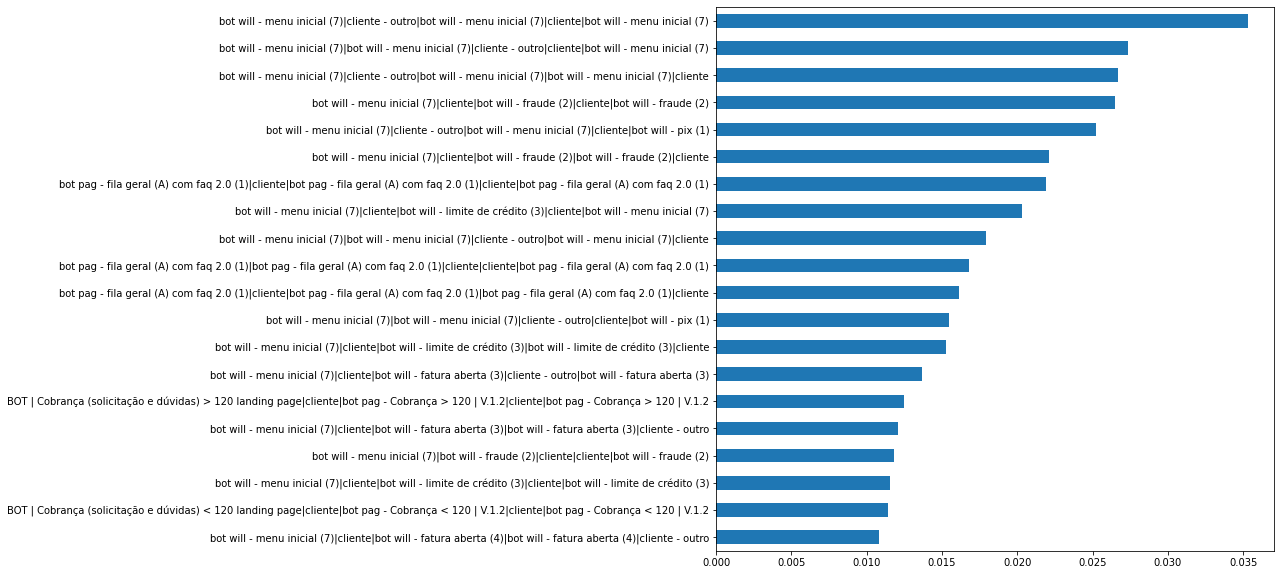

In [143]:
df_flx3['comb5'].value_counts(normalize=True)[:20].sort_values().plot(kind='barh', figsize=(10, 10))

## Frequência por fluxo - um passo após pedir pra falar de outro assunto

2


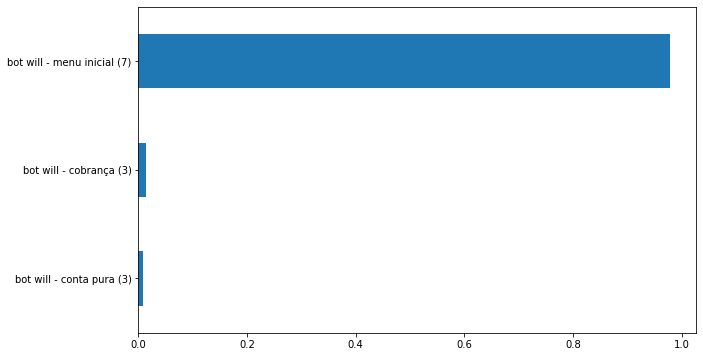

3


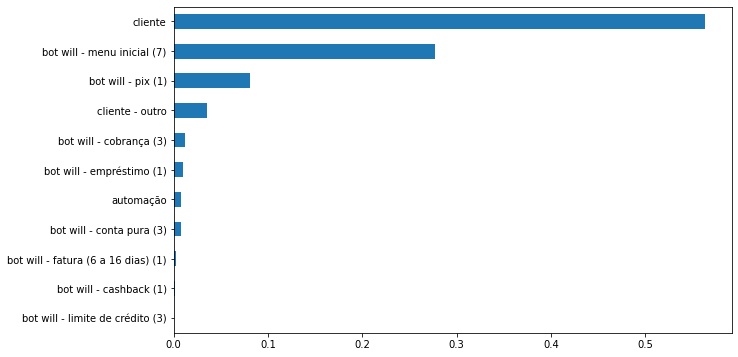

4


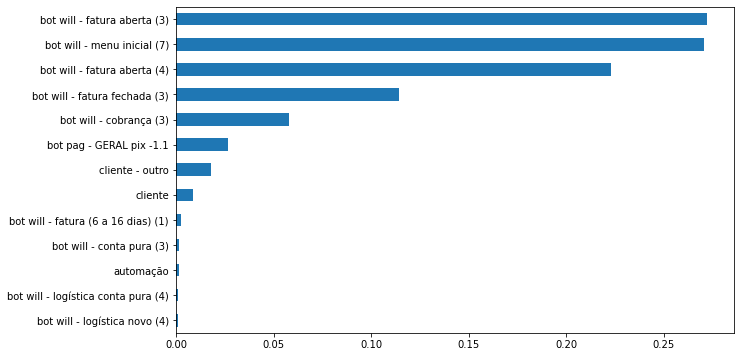

5


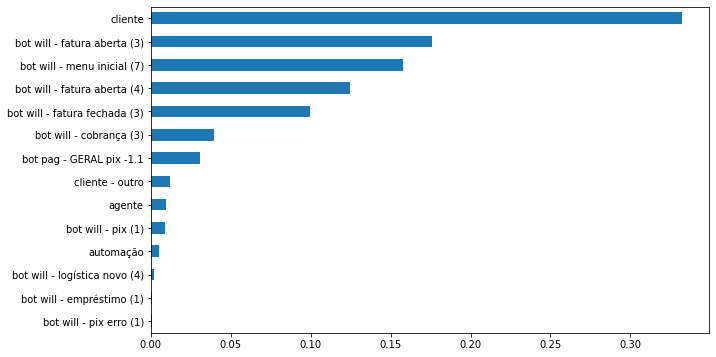

6


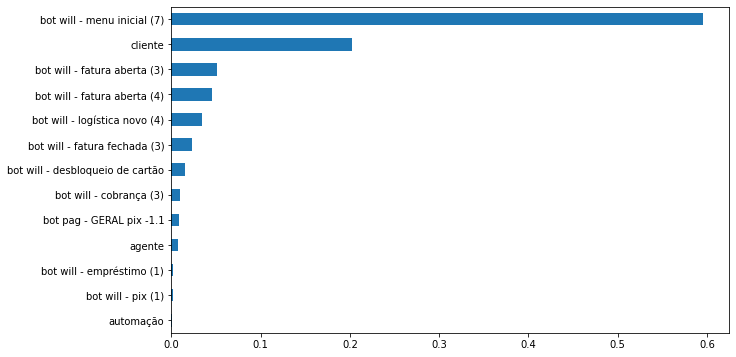

7


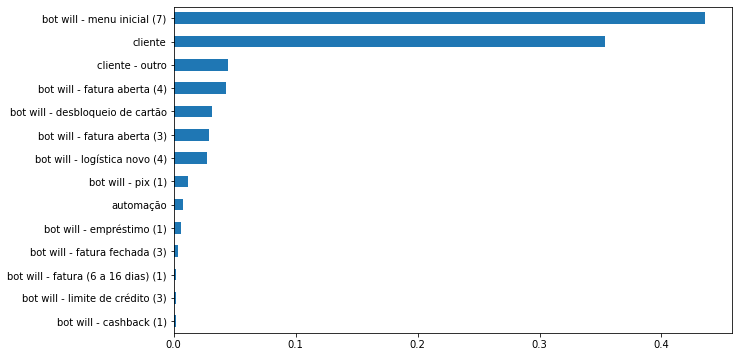

8


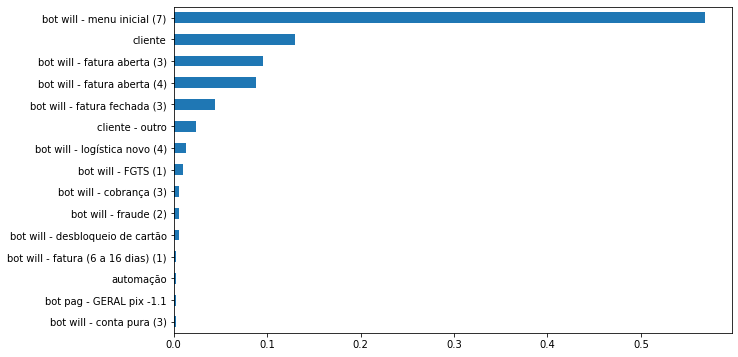

9


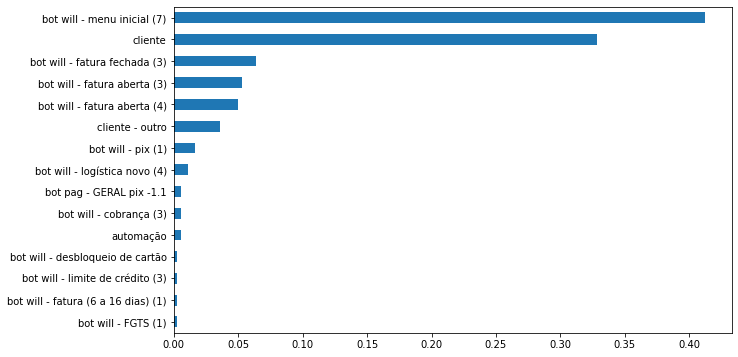

In [141]:
for i in range(2, 10):
    print(i)
    df_flx3[df_flx3['col_' + str(i)] == 'cliente - outro']['col_' + str(i+1)].value_counts(normalize=True).sort_values().plot(kind='barh', figsize=(10, 6))
    plt.show()